# Packages

In [ ]:
#!pip install pfhedge


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module
import matplotlib.pyplot as plt
from math import log, sqrt
from torch.distributions.normal import Normal


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io

In [2]:
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import BlackScholes
from pfhedge.nn import Clamp
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron
from pfhedge.nn import EntropicRiskMeasure
from pfhedge.nn import Hedger
from pfhedge.instruments import BaseDerivative
from pfhedge.features import LogMoneyness, TimeToMaturity, Volatility, PrevHedge

# Option characteristics

In [3]:
stock = BrownianStock(cost=1e-4, dt=1/250)
derivative = EuropeanOption(stock, maturity=1)
gamma = 1.0

train = False

derivative

EuropeanOption(
  strike=1., maturity=1
  (underlier): BrownianStock(sigma=0.2000, cost=1.0000e-04, dt=0.0040)
)

# Alternative Network Architecture

In [4]:
class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]

        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])

        return self.clamp(prev_hedge, min=min, max=max)


# Training and Pricing with the MLP

In [5]:
# EXAMPLE

'''torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model_MLP = MultiLayerPerceptron()
hedger_MLP = Hedger(model_MLP, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

# Fit and price
hedger_MLP.fit(derivative, n_paths=10000, n_epochs=200)
price_MLP = hedger_MLP.price(derivative, n_paths=10000)
print(f"Price={price_MLP:.5e}")'''

'torch.manual_seed(42)\n\n# Prepare a derivative to hedge\nderivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)\n\n# Create your hedger\nmodel_MLP = MultiLayerPerceptron()\nhedger_MLP = Hedger(model_MLP, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])\n\n# Fit and price\nhedger_MLP.fit(derivative, n_paths=10000, n_epochs=200)\nprice_MLP = hedger_MLP.price(derivative, n_paths=10000)\nprint(f"Price={price_MLP:.5e}")'

# Training and Pricing with the NTBN

In [6]:
#EXAMPLE 

'''torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model_NTBN = NoTransactionBandNet(derivative)
hedger_NTBN = Hedger(model_NTBN, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

# Fit and price
hedger_NTBN.fit(derivative, n_paths=10000, n_epochs=200)
price_NTBN = hedger_NTBN.price(derivative, n_paths=10000)
print(f"Price={price_NTBN:.5e}")'''

'torch.manual_seed(42)\n\n# Prepare a derivative to hedge\nderivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)\n\n# Create your hedger\nmodel_NTBN = NoTransactionBandNet(derivative)\nhedger_NTBN = Hedger(model_NTBN, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])\n\n# Fit and price\nhedger_NTBN.fit(derivative, n_paths=10000, n_epochs=200)\nprice_NTBN = hedger_NTBN.price(derivative, n_paths=10000)\nprint(f"Price={price_NTBN:.5e}")'

# Training of both networks for several different cost levels 

In [7]:
import numpy as np
for i in range(11):
    print(f'exp de {-i}={np.exp(-i)}')

exp de 0=1.0
exp de -1=0.36787944117144233
exp de -2=0.1353352832366127
exp de -3=0.049787068367863944
exp de -4=0.01831563888873418
exp de -5=0.006737946999085467
exp de -6=0.0024787521766663585
exp de -7=0.0009118819655545162
exp de -8=0.00033546262790251185
exp de -9=0.00012340980408667956
exp de -10=4.5399929762484854e-05


In [8]:
if train :
    for i in range(len(tc)):
        globals()[f'derivative_{i}'] = EuropeanOption(BrownianStock(cost=tc[i]), maturity=1)
        globals()[f'model_MLP_{i}'] = MultiLayerPerceptron()
        globals()[f'model_NTBN_{i}'] = NoTransactionBandNet(globals()[f'derivative_{i}'])
        globals()[f'hedger_MLP_{i}'] = Hedger(globals()[f'model_MLP_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_NTBN_{i}'] = Hedger(globals()[f'model_NTBN_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_{i}'].fit(globals()[f'derivative_{i}'], n_paths=10000, n_epochs=100)
        globals()[f'hedger_NTBN_{i}'].fit(globals()[f'derivative_{i}'], n_paths=10000, n_epochs=100)
        globals()[f'price_MLP_{i}'] = globals()[f'hedger_MLP_{i}'].price(globals()[f'derivative_{i}'], n_paths=10000)
        globals()[f'price_NTBN_{i}'] = globals()[f'hedger_NTBN_{i}'].price(globals()[f'derivative_{i}'], n_paths=10000)

In [9]:
'''from collections import defaultdict

derivatives = {}
models_MLP = {}
models_NTBN = {}
hedgers_MLP = {}
hedgers_NTBN = {}
prices_MLP = {}
prices_NTBN = {}

for i in range(2, 11):
    derivative = EuropeanOption(BrownianStock(cost=np.exp(-i)), maturity=1)
    model_mlp = MultiLayerPerceptron()
    model_ntbn = NoTransactionBandNet(derivative)

    hedger_mlp = Hedger(model_mlp, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    hedger_ntbn = Hedger(model_ntbn, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

    hedger_mlp.fit(derivative, n_paths=10000, n_epochs=200)
    hedger_ntbn.fit(derivative, n_paths=10000, n_epochs=200)

    # Save to dictionaries
    derivatives[i] = derivative
    models_MLP[i] = model_mlp
    models_NTBN[i] = model_ntbn
    hedgers_MLP[i] = hedger_mlp
    hedgers_NTBN[i] = hedger_ntbn

    prices_MLP[i] = hedger_mlp.price(derivative, n_paths=10000)
    prices_NTBN[i] = hedger_ntbn.price(derivative, n_paths=10000)
    
    for i in range(2, 11):
    print(f"Cost: {np.exp(-i):.4f} | MLP Price: {prices_MLP[i]:.4f} | NTBN Price: {prices_NTBN[i]:.4f}")'''

'from collections import defaultdict\n\nderivatives = {}\nmodels_MLP = {}\nmodels_NTBN = {}\nhedgers_MLP = {}\nhedgers_NTBN = {}\nprices_MLP = {}\nprices_NTBN = {}\n\nfor i in range(2, 11):\n    derivative = EuropeanOption(BrownianStock(cost=np.exp(-i)), maturity=1)\n    model_mlp = MultiLayerPerceptron()\n    model_ntbn = NoTransactionBandNet(derivative)\n\n    hedger_mlp = Hedger(model_mlp, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])\n    hedger_ntbn = Hedger(model_ntbn, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])\n\n    hedger_mlp.fit(derivative, n_paths=10000, n_epochs=200)\n    hedger_ntbn.fit(derivative, n_paths=10000, n_epochs=200)\n\n    # Save to dictionaries\n    derivatives[i] = derivative\n    models_MLP[i] = model_mlp\n    models_NTBN[i] = model_ntbn\n    hedgers_MLP[i] = hedger_mlp\n    hedgers_NTBN[i] = hedger_ntbn\n\n    prices_MLP[i] = hedger_mlp.price(derivative, n_paths=10000)\n    prices_NTBN[i] = hedger_ntbn.price(derivative, n_p

In [10]:
if train:    
    derivative_0 = EuropeanOption(BrownianStock(cost=0), maturity=1)
    model_MLP_0 = MultiLayerPerceptron()
    hedger_MLP_0 = Hedger(model_MLP_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    hedger_MLP_0.fit(derivative_0, n_paths=10000, n_epochs=100)
    model_NTBN_0 = NoTransactionBandNet(derivative_0)
    hedger_NTBN_0 = Hedger(model_NTBN_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    hedger_NTBN_0.fit(derivative_0, n_paths=10000, n_epochs=100)

    torch.save(hedger_MLP_0.state_dict(), "MLP_0.pth")
    torch.save(hedger_NTBN_0.state_dict(), "NTBN_0.pth")

In [11]:
for i in range(2,11):
    globals()[f'derivative_{i}'] = EuropeanOption(BrownianStock(cost=np.exp(-i)), maturity=1)
    globals()[f'model_MLP_{i}'] = MultiLayerPerceptron()
    globals()[f'model_NTBN_{i}'] = NoTransactionBandNet(globals()[f'derivative_{i}'])
    globals()[f'hedger_MLP_{i}'] = Hedger(globals()[f'model_MLP_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_NTBN_{i}'] = Hedger(globals()[f'model_NTBN_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_MLP_{i}'].load_state_dict(torch.load(f'MLP_{i}.pth'))
    globals()[f'hedger_NTBN_{i}'].load_state_dict(torch.load(f'NTBN_{i}.pth'))
    
derivative_0 = EuropeanOption(BrownianStock(cost=0), maturity=1)
model_MLP_0 = MultiLayerPerceptron()
hedger_MLP_0 = Hedger(model_MLP_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
model_NTBN_0 = NoTransactionBandNet(derivative_0)
hedger_NTBN_0 = Hedger(model_NTBN_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
hedger_MLP_0.load_state_dict(torch.load('MLP_0.pth'))
hedger_NTBN_0.load_state_dict(torch.load('NTBN_0.pth'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [12]:
price_MLP = []
price_NTBN = []
for i in range(2,11):
    globals()[f'hedger_MLP_{i}'].eval()
    globals()[f'hedger_NTBN_{i}'].eval()
    price_MLP.append(eval(f'hedger_MLP_{i}').price(derivative, n_paths=10000, n_times = 10).item())
    price_NTBN.append(eval(f'hedger_NTBN_{i}').price(derivative, n_paths=10000, n_times = 10).item())


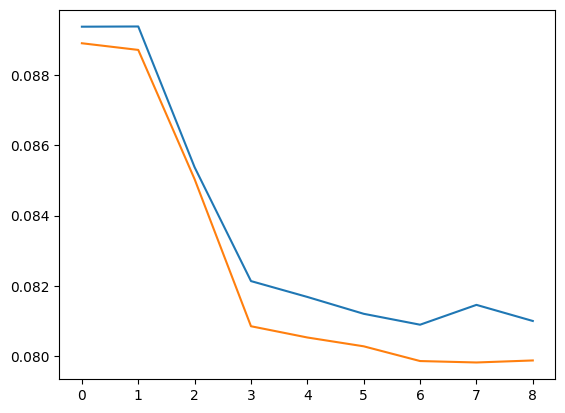

In [13]:
plt.plot(price_MLP)
plt.plot(price_NTBN)
plt.show()

In [14]:
price_MLP_0 = hedger_MLP_0.price(derivative_0, n_paths=10000, n_times=10).item()
price_NTBN_0 = hedger_NTBN_0.price(derivative_0, n_paths=10000, n_times=10).item()

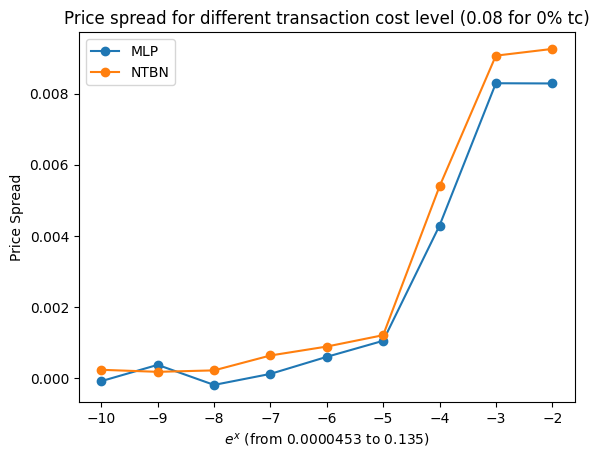

In [15]:
price_spread_MLP = np.array(price_MLP) - price_MLP_0
price_spread_NTBN = np.array(price_NTBN) - price_NTBN_0
plt.plot(list(range(-10, -1)),price_spread_MLP[::-1], 'o-', label='MLP')
plt.plot(list(range(-10, -1)),price_spread_NTBN[::-1], 'o-', label='NTBN')
plt.ylabel('Price Spread')
plt.xlabel(r'$e^x$ (from 0.0000453 to 0.135)')
plt.title('Price spread for different transaction cost level (0.08 for 0% tc)')
plt.legend()
plt.show()

In [16]:
utility_MLP = {}
utility_NTBN = {}
for i in range(2,11):
    eval(f'derivative_{i}').simulate(20000)
    wealth_MLP = []
    wealth_NTBN = []
    wealth_MLP = eval(f'hedger_MLP_{i}').compute_pl(eval(f'derivative_{i}'))
    wealth_NTBN = eval(f'hedger_NTBN_{i}').compute_pl(eval(f'derivative_{i}'))
    U_MLP = -torch.exp(-gamma * wealth_MLP)  
    U_NTBN = -torch.exp(-gamma * wealth_NTBN)  
    utility_MLP[i] = U_NTBN.mean().item()
    utility_NTBN[i] = U_NTBN.mean().item()

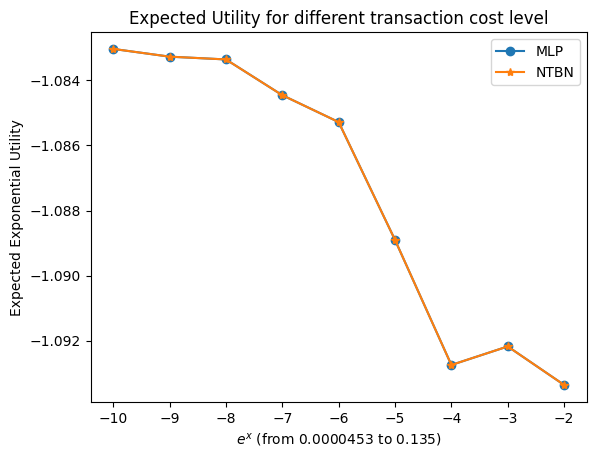

In [17]:
plt.plot(list(range(-10, -1)),list(utility_MLP.values())[::-1], 'o-', label='MLP')
plt.plot(list(range(-10, -1)),list(utility_NTBN.values())[::-1], '*-', label='NTBN')
plt.ylabel('Expected Exponential Utility')
plt.xlabel(r'$e^x$ (from 0.0000453 to 0.135)')
plt.title('Expected Utility for different transaction cost level')
plt.legend()
plt.show()

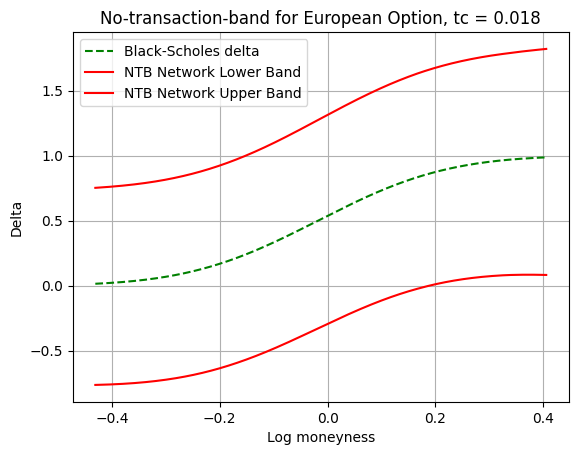

In [18]:
# Parameters
S0 = 1
K = 1
T = 1.0
sigma = 0.2
time_slice = 0.1 * T
model = hedger_NTBN_4.model  # Your trained model

# Black–Scholes delta (pure PyTorch version)
def bs_delta(S, K, T, t, sigma):
    tau = torch.tensor(T - t, dtype=S.dtype, device=S.device)
    d1 = (S / K).log().add(0.5 * sigma**2 * tau) / (sigma * tau.sqrt())
    normal = Normal(0.0, 1.0)
    return normal.cdf(d1)

# Grid of spot prices and corresponding log-moneyness
S_vals = torch.linspace(0.65 * K, 1.5 * K, 1000)
log_moneyness = (S_vals / K).log()
t_vals = torch.full_like(S_vals, time_slice)

# Prepare model input
prev_hedge = torch.zeros_like(S_vals)
x_mlp_input = torch.stack([S_vals, t_vals, prev_hedge], dim=-1)  # shape [100, 3]

# Forward pass
with torch.no_grad():
    delta_vals = bs_delta(S_vals, K, T, time_slice, sigma)
    width_vals = model.mlp(x_mlp_input)
    lower = delta_vals - torch.nn.functional.leaky_relu(width_vals[:, 0])
    upper = delta_vals + torch.nn.functional.leaky_relu(width_vals[:, 1])

# Plot
plt.plot(log_moneyness.tolist(), delta_vals.tolist(), linestyle='--', color='green', label="Black-Scholes delta")
plt.plot(log_moneyness.tolist(), lower.tolist(), color='red', label="NTB Network Lower Band")
plt.plot(log_moneyness.tolist(), upper.tolist(), color='red', label="NTB Network Upper Band")
plt.xlabel("Log moneyness")
plt.ylabel("Delta")
plt.title(f"No-transaction-band for European Option, tc = {np.exp(-4):.3f}")
plt.legend()
plt.grid(True)
plt.show()



# Trade metrics : Trade frequency and Number of shares traded

In [19]:
'''hedge = hedger_NTBN.simulate(derivative, n_paths=1000)["hedge"]'''

'hedge = hedger_NTBN.simulate(derivative, n_paths=1000)["hedge"]'

In [20]:
def compute_trade_frequency_pfhedge(hedge: torch.Tensor) -> float:
    """
    hedge: Tensor of shape (n_paths, n_steps)
    Returns: fraction of time steps where the hedge changes
    """
    hedge_diff = hedge[:, 1:] - hedge[:, :-1]
    traded = (hedge_diff != 0).sum().item()
    total = hedge_diff.numel()
    return traded / total

def compute_avg_num_shares_traded_pfhedge(hedge: torch.Tensor) -> float:
    """
    hedge: Tensor of shape (n_paths, n_steps)
    Returns: average number of shares traded per time step, per path
    """
    hedge_diff = hedge[:, 1:] - hedge[:, :-1]
    total_traded = hedge_diff.abs().sum().item()
    total_steps = hedge_diff.numel()
    return total_traded / total_steps

In [21]:
derivative.simulate(n_paths = 1000)
derivative_2.simulate(n_paths = 1000)
derivative_3.simulate(n_paths = 1000)
derivative_4.simulate(n_paths = 1000)
derivative_5.simulate(n_paths = 1000)
derivative_6.simulate(n_paths = 1000)
derivative_7.simulate(n_paths = 1000)
derivative_8.simulate(n_paths = 1000)
derivative_9.simulate(n_paths = 1000)
derivative_10.simulate(n_paths = 1000)
hedge = hedger_NTBN_0.compute_hedge(derivative)
hedge = hedge.squeeze(1)  # Now shape is (1000, 251)
hedge2 = hedger_NTBN_2.compute_hedge(derivative_2)
hedge2 = hedge2.squeeze(1)  # Now shape is (1000, 251)
hedge3 = hedger_NTBN_3.compute_hedge(derivative_3)
hedge3 = hedge3.squeeze(1)  # Now shape is (1000, 251)
hedge4 = hedger_NTBN_4.compute_hedge(derivative_4)
hedge4 = hedge4.squeeze(1)  # Now shape is (1000, 251)
hedge5 = hedger_NTBN_5.compute_hedge(derivative_5)
hedge5 = hedge5.squeeze(1)  # Now shape is (1000, 251)
hedge6 = hedger_NTBN_6.compute_hedge(derivative_6)
hedge6 = hedge6.squeeze(1)  # Now shape is (1000, 251)
hedge7 = hedger_NTBN_7.compute_hedge(derivative_7)
hedge7 = hedge7.squeeze(1)  # Now shape is (1000, 251)
hedge8 = hedger_NTBN_8.compute_hedge(derivative_8)
hedge8 = hedge8.squeeze(1)  # Now shape is (1000, 251)
hedge9 = hedger_NTBN_9.compute_hedge(derivative_9)
hedge9 = hedge9.squeeze(1)  # Now shape is (1000, 251)
hedge10 = hedger_NTBN_10.compute_hedge(derivative_10)
hedge10 = hedge10.squeeze(1)  # Now shape is (1000, 251)

trade_freq = []
trade_freq.append(compute_trade_frequency_pfhedge(hedge))
avg_shares = []
avg_shares.append(compute_avg_num_shares_traded_pfhedge(hedge))

for i in range(10,1,-1):
    trade_freq.append(compute_trade_frequency_pfhedge(eval(f'hedge{i}')))
    avg_shares.append(compute_avg_num_shares_traded_pfhedge(eval(f'hedge{i}')))
    

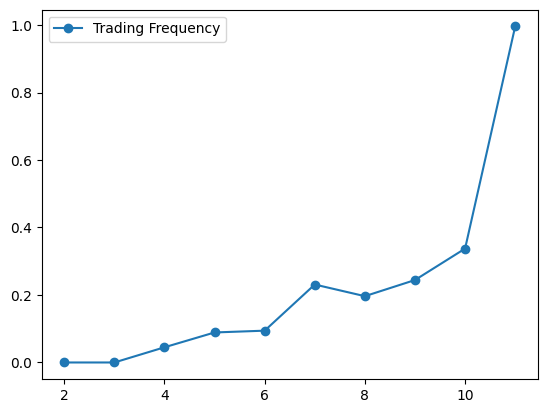

In [22]:
plt.plot(range(11,1,-1),trade_freq, marker='o', label='Trading Frequency')
plt.legend()
plt.show()


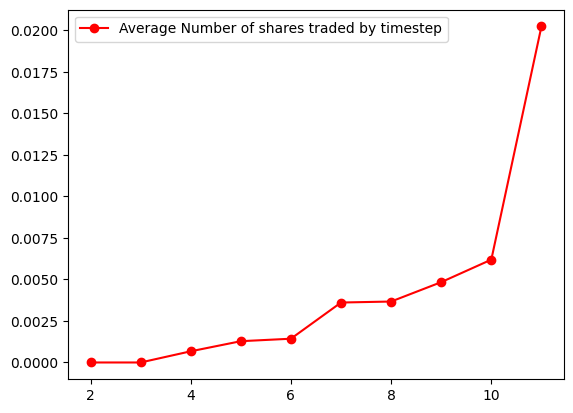

In [23]:
plt.plot(range(11,1,-1),avg_shares, c='red', marker='o', label='Average Number of shares traded by timestep')
plt.legend()
plt.show()

# Call Spread

In [ ]:
'''K1 = 0.9
K2 = 1.1
maturity = 1.0
tc = 1e-4

stock = BrownianStock(cost=tc, dt=1/250)

call_1 = EuropeanOption(stock, strike=K1, maturity=maturity)
call_2 = EuropeanOption(stock, strike=K2, maturity=maturity)

hedger_call1 = Hedger(MultiLayerPerceptron(), ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
hedger_call1.fit(call_1, n_paths=10000, n_epochs=30)
price_call1 = hedger_call1.price(call_1, n_paths=10000)

hedger_call2 = Hedger(MultiLayerPerceptron(), ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
hedger_call2.fit(call_2, n_paths=10000, n_epochs=30)
price_call2 = hedger_call2.price(call_2, n_paths=10000)

price_spread_indirect = price_call1 - price_call2
print(f"Indirect call spread price (K={K1}-{K2}): {price_spread_indirect:.5f}")'''


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Python(11410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Loss=0.1434: 100%|██████████| 30/30 [01:49<00:00,  3.64s/it]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.0439: 100%|██████████| 30/30 [01:47<00:00,  3.57s/it]


Indirect call spread price (K=0.9-1.1): 0.09700


In [ ]:
class CallSpread(BaseDerivative):
    def __init__(self, underlier, strike_long, strike_short, maturity=1.0):
        super().__init__()
        self.underlier = underlier
        self.strike_long = strike_long
        self.strike_short = strike_short
        self.maturity = maturity

    def payoff_fn(self):
        spot = self.underlier.spot
        return torch.clamp(spot[..., -1] - self.strike_long, min=0) - torch.clamp(spot[..., -1] - self.strike_short, min=0)

    def moneyness(self, time_step=None, log=False):
        spot = self.underlier.spot
        index = ... if time_step is None else [time_step]
        output = spot[..., index] / self.strike_long
        if log:
            output = output.log()
        return output

    def log_moneyness(self, time_step=None):
        return self.moneyness(time_step=time_step, log=True)

    def time_to_maturity(self, time_step=None):
        spot = self.underlier.spot
        n_paths, n_steps = spot.size()
        if time_step is None:
            t = torch.arange(n_steps).to(spot) * self.underlier.dt
            return (t[-1] - t).unsqueeze(0).expand(n_paths, -1)
        else:
            time = n_steps - (time_step % n_steps) - 1
            t = torch.tensor([[time]]).to(spot) * self.underlier.dt
            return t.expand(n_paths, -1)

    def setup_features(self):
        self.features.add(LogMoneyness(self))
        self.features.add(TimeToMaturity(self))
        self.features.add(Volatility(self))
        self.features.add(PrevHedge())

    def extra_repr(self):
        return f"CallSpread(strike_long={self.strike_long}, strike_short={self.strike_short}, maturity={self.maturity})"


'''K1 = 0.9
K2 = 1.1
maturity = 1.0
cost = 1e-4
gamma = 1.0

stock = BrownianStock(cost=cost, dt=1/250)
callspread = CallSpread(stock, strike_long=K1, strike_short=K2, maturity=maturity)

model = MultiLayerPerceptron()
hedger = Hedger(
    model,
    ["log_moneyness", "expiry_time", "volatility", "prev_hedge"],
    criterion=EntropicRiskMeasure(gamma)
)

hedger.fit(callspread, n_paths=10000, n_epochs=30)
price_spread_direct = hedger.price(callspread, n_paths=10000)
print(f"Direct call spread price (K={K1}-{K2}): {price_spread_direct:.5f}")'''

Loss=0.0939: 100%|██████████| 30/30 [01:50<00:00,  3.69s/it]


Direct call spread price (K=0.9-1.1): 0.09495


In [ ]:
'''diff = abs(price_spread_direct - price_spread_indirect)
print(f"Absolute difference between direct and indirect: {diff:.5e}")'''

Absolute difference between direct and indirect: 2.05135e-03


## Training of different models for different transaction costs levels

In [27]:
tc = [0, 0.0001, 0.001, 0.01, 0.03]
K1 = 0.9
K2 = 1.1

In [ ]:
train_cs = False

In [29]:
if train_cs:
    for i in tc:
        globals()[f'derivative_K1_{i}'] = EuropeanOption(BrownianStock(cost=i), strike=K1, maturity=1)
        globals()[f'model_NTBN_K1_{i}'] = NoTransactionBandNet(globals()[f'derivative_K1_{i}'])
        globals()[f'hedger_NTBN_K1_{i}'] = Hedger(globals()[f'model_NTBN_K1_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_NTBN_K1_{i}'].fit(globals()[f'derivative_K1_{i}'], n_paths=5000, n_epochs=50)
        globals()[f'price_NTBN_K1_{i}'] = globals()[f'hedger_NTBN_K1_{i}'].price(globals()[f'derivative_K1_{i}'], n_paths=5000)
        
        torch.save(globals()[f'hedger_NTBN_K1_{i}'].state_dict(), f"NTBN_K1_{i}.pth")


Loss=0.1629: 100%|██████████| 50/50 [02:08<00:00,  2.56s/it]


In [30]:
if train_cs: 
    for i in tc:
        globals()[f'derivative_K2_{i}'] = EuropeanOption(BrownianStock(cost=i), strike=K2, maturity=1)
        globals()[f'model_NTBN_K2_{i}'] = NoTransactionBandNet(globals()[f'derivative_K2_{i}'])
        globals()[f'hedger_NTBN_K2_{i}'] = Hedger(globals()[f'model_NTBN_K2_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_NTBN_K2_{i}'].fit(globals()[f'derivative_K2_{i}'], n_paths=5000, n_epochs=50)
        globals()[f'price_NTBN_K2_{i}'] = globals()[f'hedger_NTBN_K2_{i}'].price(globals()[f'derivative_K2_{i}'], n_paths=5000)
        
        torch.save(globals()[f'hedger_NTBN_K2_{i}'].state_dict(), f"NTBN_K2_{i}.pth")

Loss=0.0646: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it]


In [31]:
if train_cs: 
    for i in tc:
        globals()[f'derivative_cs_{i}'] = CallSpread(BrownianStock(cost=i), strike_long=K1, strike_short=K2, maturity=1)
        globals()[f'model_MLP_cs_{i}'] = MultiLayerPerceptron()
        globals()[f'hedger_MLP_cs_{i}'] = Hedger(globals()[f'model_MLP_cs_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
        globals()[f'hedger_MLP_cs_{i}'].fit(globals()[f'derivative_cs_{i}'], n_paths=5000, n_epochs=50)
        globals()[f'price_MLP_cs_{i}'] = globals()[f'hedger_MLP_cs_{i}'].price(globals()[f'derivative_cs_{i}'], n_paths=5000)
        
        torch.save(globals()[f'hedger_MLP_cs_{i}'].state_dict(), f"MLP_cs_{i}.pth")

Loss=0.0962: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


In [35]:
for i in range(len(tc)):
    globals()[f'derivative_K1_{i}'] = EuropeanOption(BrownianStock(cost=tc[i]), strike=K1, maturity=1)
    globals()[f'model_NTBN_K1_{i}'] = NoTransactionBandNet(globals()[f'derivative_K1_{i}'])
    globals()[f'hedger_NTBN_K1_{i}'] = Hedger(globals()[f'model_NTBN_K1_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_NTBN_K1_{i}'].load_state_dict(torch.load(f'NTBN_K1_{tc[i]}.pth'))

    globals()[f'derivative_K2_{i}'] = EuropeanOption(BrownianStock(cost=tc[i]), strike=K2, maturity=1)
    globals()[f'model_NTBN_K2_{i}'] = NoTransactionBandNet(globals()[f'derivative_K2_{i}'])
    globals()[f'hedger_NTBN_K2_{i}'] = Hedger(globals()[f'model_NTBN_K2_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_NTBN_K2_{i}'].load_state_dict(torch.load(f'NTBN_K2_{tc[i]}.pth'))

    globals()[f'derivative_cs_{i}'] = CallSpread(BrownianStock(cost=tc[i]), strike_long=K1, strike_short=K2, maturity=1)
    globals()[f'model_MLP_cs_{i}'] = MultiLayerPerceptron()
    globals()[f'hedger_MLP_cs_{i}'] = Hedger(globals()[f'model_MLP_cs_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_MLP_cs_{i}'].load_state_dict(torch.load(f'MLP_cs_{tc[i]}.pth'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Prices Comparison

In [36]:
price_K1 = []
price_K2 = []
price_cs = []

for i in range(len(tc)):
    globals()[f'hedger_MLP_cs_{i}'].eval()
    globals()[f'hedger_NTBN_K1_{i}'].eval()
    globals()[f'hedger_NTBN_K2_{i}'].eval()
    price_cs.append(eval(f'hedger_MLP_cs_{i}').price(derivative, n_paths=10000, n_times = 10).item())
    price_K1.append(eval(f'hedger_NTBN_K1_{i}').price(derivative, n_paths=10000, n_times = 10).item())
    price_K2.append(eval(f'hedger_NTBN_K2_{i}').price(derivative, n_paths=10000, n_times = 10).item())
    
price_K1_K2 = [price_K1[i] - price_K2[i] for i in range(len(price_K1))]


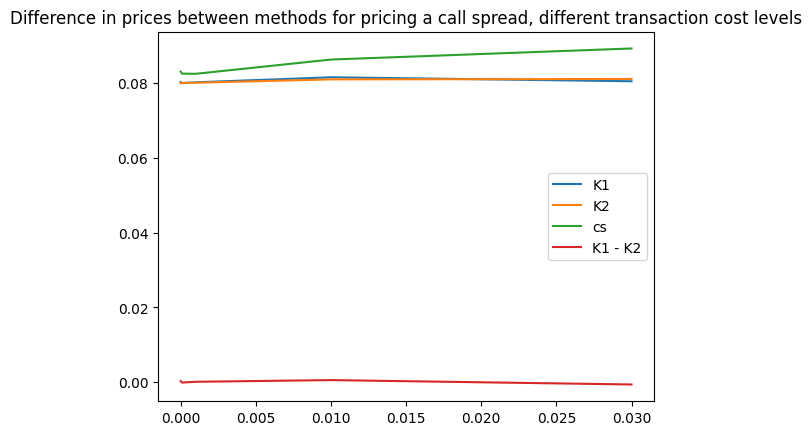

In [37]:

plt.plot(tc, price_K1, label='K1')
plt.plot(tc, price_K2, label='K2')
plt.plot(tc, price_cs, label='cs')
plt.plot(tc, price_K1_K2, label='K1 - K2')
plt.title('Difference in prices between methods for pricing a call spread, different transaction cost levels')
plt.legend()
plt.show()